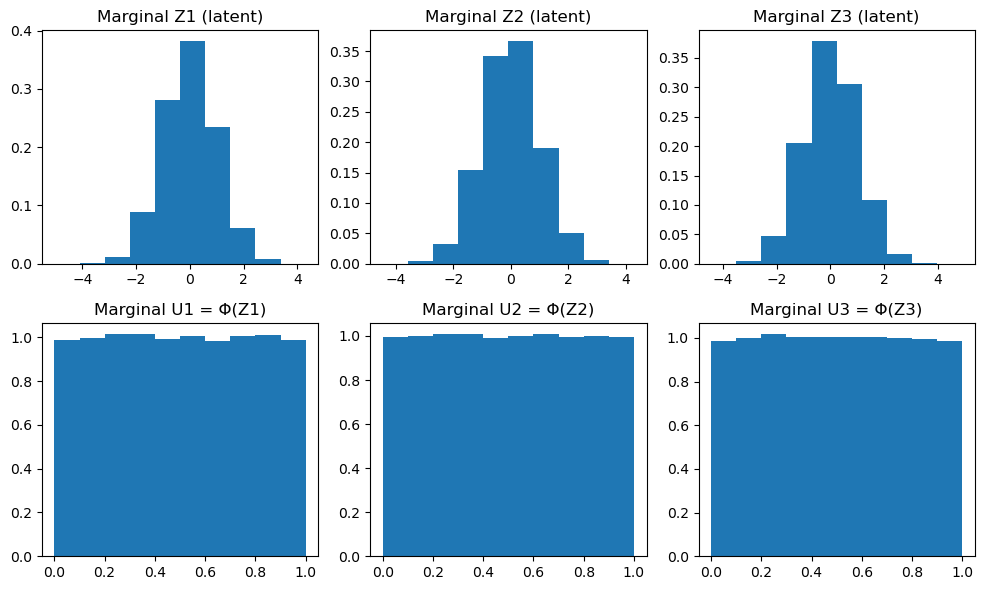

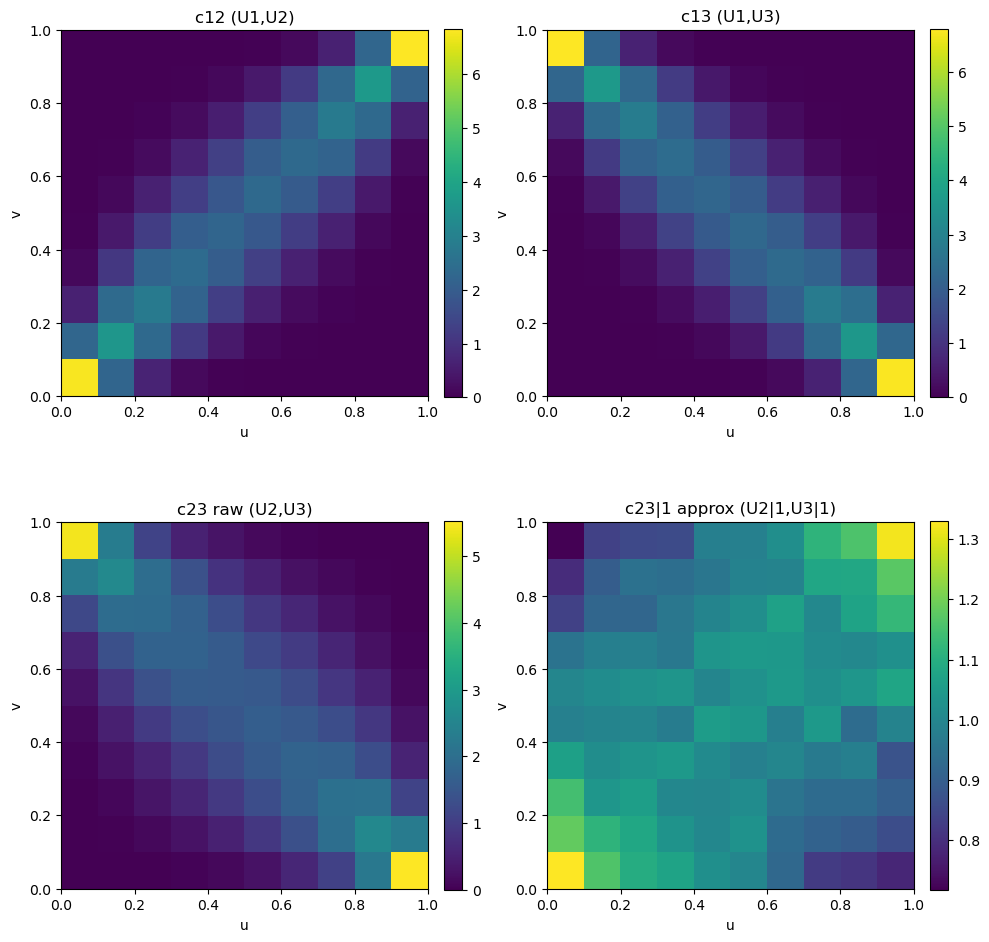

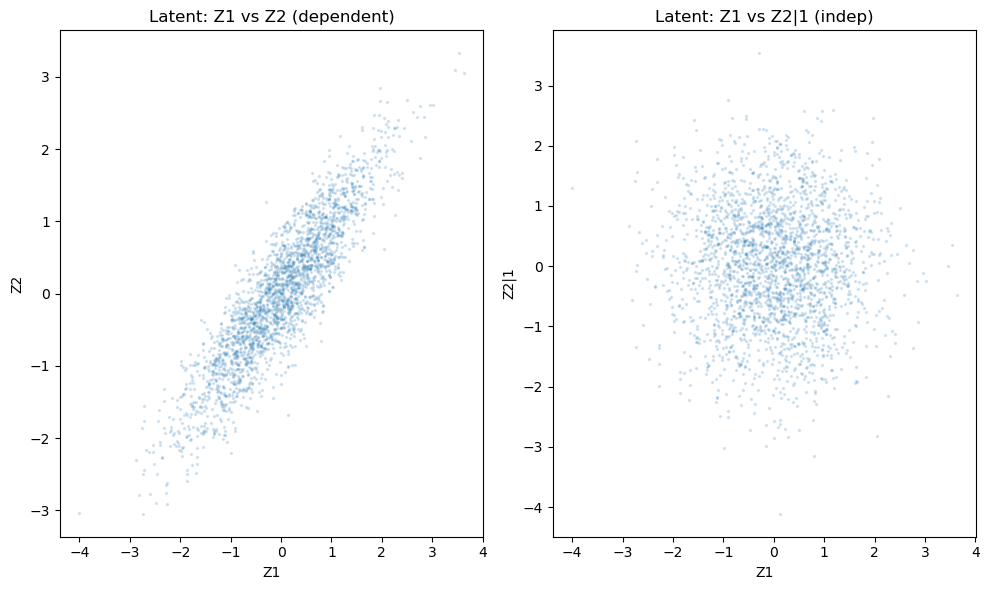

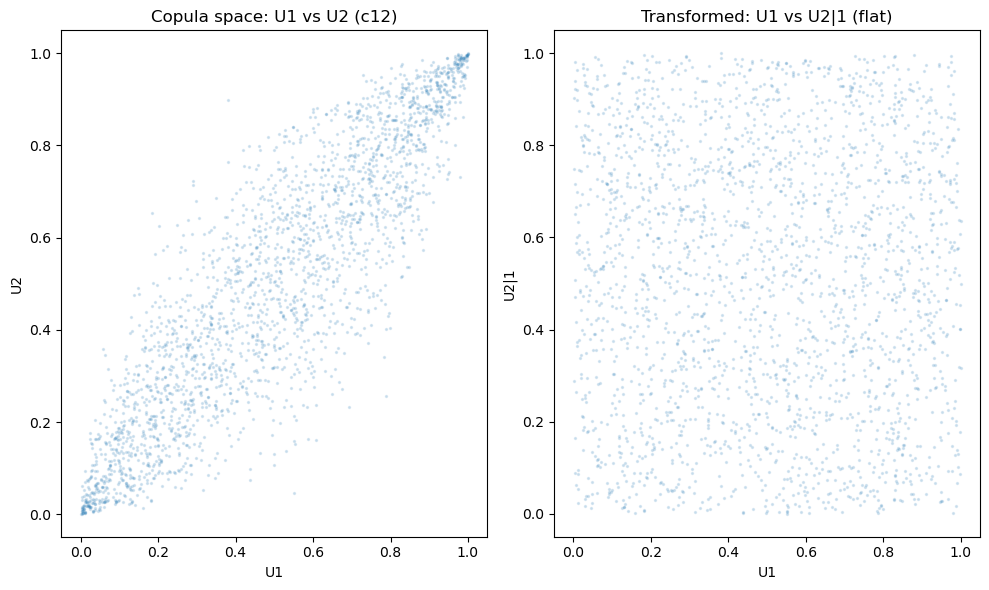

,Pair,Spearman_rho
0,U1-U2,0.890231
1,U1-U3,-0.890996
2,U2-U3 raw,-0.775791
3,U1-U2|1,0.001424
4,U1-U3|1,0.002811
5,U2|1-U3|1,0.092108


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

def implied_r23(r12, r13, r23_given_1):
    return r12*r13 + r23_given_1*np.sqrt((1-r12**2)*(1-r13**2))

def sample_gaussian_copula_3d(n, r12, r13, r23_given_1, seed=0):
    r23 = implied_r23(r12, r13, r23_given_1)
    R = np.array([[1, r12, r13],
                  [r12, 1, r23],
                  [r13, r23, 1]], dtype=float)
    rng = np.random.default_rng(seed)
    Z = rng.multivariate_normal(np.zeros(3), R, size=n)
    U = norm.cdf(Z)
    return Z, U, R

def gaussian_vine_remove_1(Z, r12, r13):
    z1, z2, z3 = Z[:,0], Z[:,1], Z[:,2]
    z2g1 = (z2 - r12*z1)/np.sqrt(1-r12**2)
    z3g1 = (z3 - r13*z1)/np.sqrt(1-r13**2)
    return norm.cdf(z2g1), norm.cdf(z3g1), z2g1, z3g1

def density_grid(Ua, Ub, bins=120):
    # 2D histogram density on [0,1]^2, normalized to integrate ~1
    H, xedges, yedges = np.histogram2d(Ua, Ub, bins=bins, range=[[0,1],[0,1]], density=True)
    # Return centers for plotting with imshow
    xc = (xedges[:-1] + xedges[1:])/2
    yc = (yedges[:-1] + yedges[1:])/2
    return H.T, xc, yc  # transpose so rows correspond to y for imshow(origin='lower')

# Parameters
n = 120000
bins = 10
r12, r13, r23_1 = 0.9, -0.9, 0.1  # set conditional coupling between 2 and 3 given 1
Z, U, R = sample_gaussian_copula_3d(n, r12, r13, r23_1, seed=1)
u1, u2, u3 = U[:,0], U[:,1], U[:,2]

u2g1, u3g1, z2g1, z3g1 = gaussian_vine_remove_1(Z, r12, r13)

# --- Figure 1: Marginals in Z-space and U-space ---
fig1 = plt.figure(figsize=(10,6))
ax = fig1.add_subplot(2,3,1)
ax.hist(Z[:,0], bins=bins, density=True)
ax.set_title("Marginal Z1 (latent)")
ax = fig1.add_subplot(2,3,2)
ax.hist(Z[:,1], bins=bins, density=True)
ax.set_title("Marginal Z2 (latent)")
ax = fig1.add_subplot(2,3,3)
ax.hist(Z[:,2], bins=bins, density=True)
ax.set_title("Marginal Z3 (latent)")

ax = fig1.add_subplot(2,3,4)
ax.hist(u1, bins=bins, density=True, range=(0,1))
ax.set_title("Marginal U1 = Φ(Z1)")
ax = fig1.add_subplot(2,3,5)
ax.hist(u2, bins=bins, density=True, range=(0,1))
ax.set_title("Marginal U2 = Φ(Z2)")
ax = fig1.add_subplot(2,3,6)
ax.hist(u3, bins=bins, density=True, range=(0,1))
ax.set_title("Marginal U3 = Φ(Z3)")
fig1.tight_layout()

# --- Figure 2: Copula densities on unit square (pairwise) ---
pairs = [("c12 (U1,U2)", u1, u2),
         ("c13 (U1,U3)", u1, u3),
         ("c23 raw (U2,U3)", u2, u3),
         ("c23|1 approx (U2|1,U3|1)", u2g1, u3g1)]
fig2 = plt.figure(figsize=(10,10))
for i,(title,a,b) in enumerate(pairs, start=1):
    H, xc, yc = density_grid(a,b,bins=bins)
    ax = fig2.add_subplot(2,2,i)
    im = ax.imshow(H, origin="lower", extent=[0,1,0,1], aspect="equal")
    ax.set_title(title)
    ax.set_xlabel("u")
    ax.set_ylabel("v")
    fig2.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig2.tight_layout()

# --- Figure 3: "Remove dependence" in latent space: Z1 vs Z2 and Z1 vs Z2|1 ---
fig3 = plt.figure(figsize=(10,6))
ax = fig3.add_subplot(1,2,1)
ax.scatter(Z[::50,0], Z[::50,1], s=2, alpha=0.15)
ax.set_title("Latent: Z1 vs Z2 (dependent)")
ax.set_xlabel("Z1")
ax.set_ylabel("Z2")
ax = fig3.add_subplot(1,2,2)
ax.scatter(Z[::50,0], z2g1[::50], s=2, alpha=0.15)
ax.set_title("Latent: Z1 vs Z2|1 (indep)")
ax.set_xlabel("Z1")
ax.set_ylabel("Z2|1")
fig3.tight_layout()

# --- Figure 4: Uniform-space: U1 vs U2 and U1 vs U2|1 ---
fig4 = plt.figure(figsize=(10,6))
ax = fig4.add_subplot(1,2,1)
ax.scatter(u1[::50], u2[::50], s=2, alpha=0.15)
ax.set_title("Copula space: U1 vs U2 (c12)")
ax.set_xlabel("U1")
ax.set_ylabel("U2")
ax = fig4.add_subplot(1,2,2)
ax.scatter(u1[::50], u2g1[::50], s=2, alpha=0.15)
ax.set_title("Transformed: U1 vs U2|1 (flat)")
ax.set_xlabel("U1")
ax.set_ylabel("U2|1")
fig4.tight_layout()

plt.show()

# Provide quick numeric checks in a small table
from scipy.stats import spearmanr
def spr(a,b): return float(spearmanr(a,b).statistic)
df = pd.DataFrame({
    "Pair": ["U1-U2","U1-U3","U2-U3 raw","U1-U2|1","U1-U3|1","U2|1-U3|1"],
    "Spearman_rho": [spr(u1,u2), spr(u1,u3), spr(u2,u3), spr(u1,u2g1), spr(u1,u3g1), spr(u2g1,u3g1)]
})
df


In [10]:
U.shape

(120000, 3)